In [18]:
import numpy as np
import pandas as pd
import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import math
import cPickle
import os
import json
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import sort
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(0)
# Force matplotlib to not use any Xwindows backend.

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Read the data that Ajay labeled. Convert 1,000 to 1000
from IPython.core.debugger import Tracer
training_data_path = os.path.join(os.environ['DATA_DIR'], 'numerai_training_data.csv')
prediction_data_path = os.path.join(os.environ['DATA_DIR'], 'numerai_tournament_data.csv')
print("Loading data...")
# Load the data from the CSV files
training_data = pd.read_csv(training_data_path, header=0)
prediction_data = pd.read_csv(prediction_data_path, header=0)

Loading data...


In [5]:
# Some clean up. Replace #DIV/0! with 0
# I think 0 is a reasonable, non-biasing number because if, e.g. #Months is 0, a spend per month of 0 is reasonable
training_data.replace(to_replace='#DIV/0!',value='0',inplace=True)
training_data.fillna(0, inplace=True)
prediction_data.replace(to_replace='#DIV/0!',value='0',inplace=True)
prediction_data.fillna(0, inplace=True)
# Transform the loaded CSV data into numpy arrays
features = [f for f in list(training_data) if "feature" in f]
X = training_data[features]
Y = training_data["target"]
X_test = prediction_data[features]
Y_test = prediction_data["target"]
ids = prediction_data["id"]
X.sort_index(axis=1, inplace=True)
X_test.sort_index(axis=1, inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108405 entries, 0 to 108404
Data columns (total 21 columns):
feature1     108405 non-null float64
feature10    108405 non-null float64
feature11    108405 non-null float64
feature12    108405 non-null float64
feature13    108405 non-null float64
feature14    108405 non-null float64
feature15    108405 non-null float64
feature16    108405 non-null float64
feature17    108405 non-null float64
feature18    108405 non-null float64
feature19    108405 non-null float64
feature2     108405 non-null float64
feature20    108405 non-null float64
feature21    108405 non-null float64
feature3     108405 non-null float64
feature4     108405 non-null float64
feature5     108405 non-null float64
feature6     108405 non-null float64
feature7     108405 non-null float64
feature8     108405 non-null float64
feature9     108405 non-null float64
dtypes: float64(21)
memory usage: 17.4 MB


In [7]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

training_data.reset_index( drop = True, inplace = True )
Y = le.fit_transform(Y)

#### Exploratory Data Analysis
**Correlation coefficient plot:**

Let us look at the correlation of each of the variables with the target variables to get some important variables to be used for our next steps.

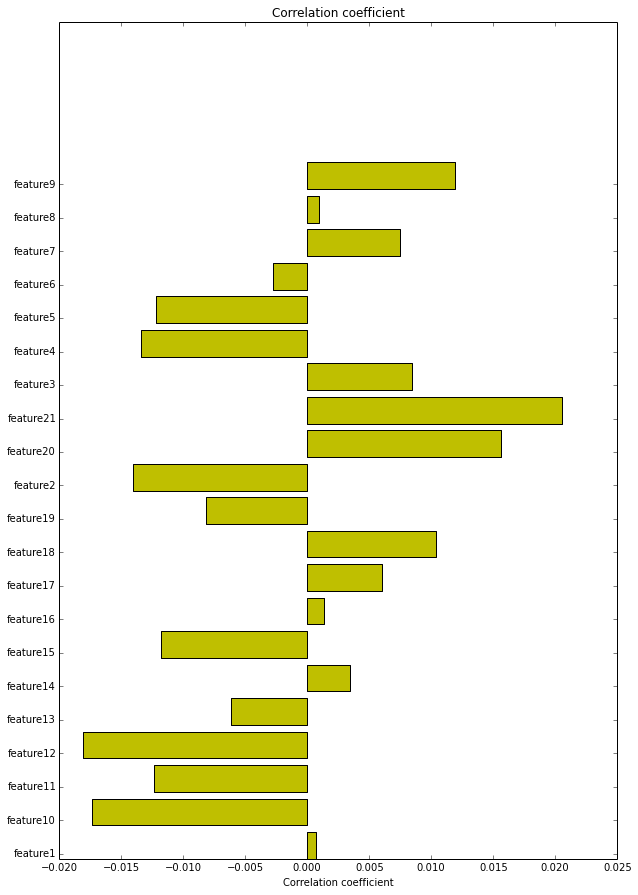

In [8]:
# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in X.columns]

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(training_data[col].values, training_data['target'].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots(figsize=(10,15))
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()

As expected, the correlation coefficient values are very low and the maximum value is around 0.022 (in positive) as seen from the plot above.

Let us take the top 4 variables from the plot above and do some more analysis on them alone.

 - feature2
 - feature10
 - feature12
 - feature21

As a first step, let us get the correlation coefficient in between these variables. 

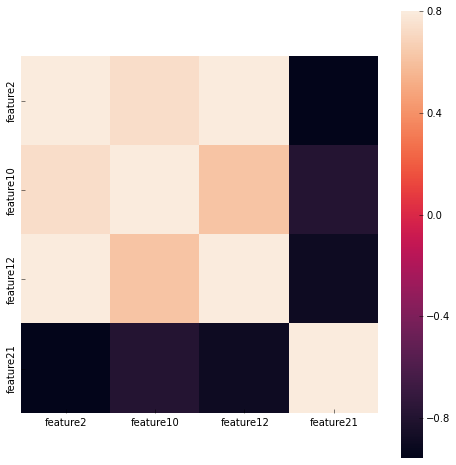

In [10]:
cols_to_use = ['feature2', 'feature10', 'feature12', 'feature21']
temp_df = training_data[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

There is some negative correlation between 'feature_21' and 'feature_2','feature_10','feature_12'.
There is positive correlation between 'feature_2','feature_10','feature_12'. 

Now, let us build a basic xgboost model and then followed by xgboost model with PCA dimensional reduction.
Number of dimensions can now be based on reduction of number of features having high positive correlation, since it may not provide any significant new information for model. 

In [11]:
X.fillna(0, inplace=True)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [12]:
#*** Split into training and testing data
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
X_train.sort_index(axis=1, inplace=True)
X_test.sort_index(axis=1,inplace=True)
X_val.sort_index(axis=1,inplace=True)

In [13]:
unique, counts = np.unique(y_train, return_counts=True)
# Number of classes and number of examples for each class
print "Train set"
print unique
print counts
dict(zip(unique, counts))
# Number of examples for validation set
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))
print "Validation set"
print unique
print counts

Train set
[0 1]
[43010 43714]
Validation set
[0 1]
[10739 10942]


Since the number of examples for each set is around the same number there wont be a problem of imbalanced data sets
#### Building initial XGBoost model

In [15]:
from xgboost import XGBClassifier, plot_importance
model = XGBClassifier() 

model.fit(X_train, y_train)

#scores = cross_val_score(model, X, y, cv=5)
#print (scores.mean())

#*** Test
y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

#*** Get Accuracy
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_val, y_val_pred)
train_acc = accuracy_score(y_train, y_train_pred)
print ('Train accuracy: ', train_acc)
print ('Test accuracy: ', test_acc)

('Train accuracy: ', 0.54450901711175681)
('Test accuracy: ', 0.51201512845348462)


In [19]:
print("Predicting...")
# Your trained model is now used to make predictions on the numerai_tournament_data
# The model returns two columns: [probability of 0, probability of 1]
# We are just interested in the probability that the target is 1.
y_test_pred = model.predict_proba(X_test)
results = y_test_pred[:, 1]
results_df = pd.DataFrame(data={'probability':results})
joined = pd.DataFrame(ids).join(results_df)

Predicting...


In [20]:
#save the config
config = {'model_type':'xgboost', 'features':str(sort(features))}
config_filename = os.path.join(os.environ['INPUT_DIR'],'config.json')
with open(config_filename, 'wb') as f:
    f.write(json.dumps(config))
# save the classifier
stats = {"train accuracy": train_acc,"test accuracy":test_acc}
metadata = {'label':'initial'}
# Save the predictions out to a CSV file
predictions_path = os.path.join(os.environ['OUTPUT_DIR'], 'predictions.csv')
joined.to_csv(predictions_path, index=False)
model_filename = os.path.join(os.environ['OUTPUT_DIR'],'model.dat')
pickle.dump(model, open(model_filename, 'wb'))
metadata_filename = os.path.join(os.environ['OUTPUT_DIR'],'metadata.json')
pickle.dump(model, open(metadata_filename, 'wb'))
stats_filename = os.path.join(os.environ['OUTPUT_DIR'],'stats.json')
with open(stats_filename, 'wb') as f:
    f.write(json.dumps(stats))

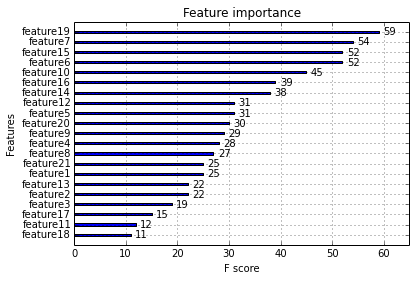

In [21]:
#Feature importance
plot_importance(model)

#### Dimensionality reduction 
Reducing the dimension before training the final XGboost model

In [22]:
import operator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

thresholds = sort(model.feature_importances_)
thresh = thresholds[-2]
best_feature_list = []
best_accuracy = -1*float("inf")
best_model = None

# list of features sorted by their importance
fscore_dict = model.booster().get_fscore()
sorted_fscore_dict = sorted(fscore_dict.items(), key=lambda x: x[1], reverse=True)
sorted_important_features_list = []
for item in sorted_fscore_dict:
    sorted_important_features_list.append(item[0])
    
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    transformed_X_train = selection.transform(X_train)
    sorted_feature_list = sorted(fscore_dict.items(), key=operator.itemgetter(1))
    feature_list = sort(sorted_important_features_list[:transformed_X_train.shape[1]])
    select_X_train = X_train[feature_list]
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)    
    # eval model
    select_X_val = X_val[feature_list]
    y_pred = selection_model.predict(select_X_val)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_val, predictions)
    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_feature_list = feature_list
        best_model = selection_model
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

print "Best feature list:"
print best_feature_list

Thresh=0.017, n=21, Accuracy: 51.20%
Thresh=0.018, n=20, Accuracy: 51.05%
Thresh=0.023, n=19, Accuracy: 51.16%
Thresh=0.029, n=18, Accuracy: 51.02%
Thresh=0.033, n=17, Accuracy: 51.18%
Thresh=0.033, n=17, Accuracy: 51.18%
Thresh=0.038, n=15, Accuracy: 51.13%
Thresh=0.038, n=15, Accuracy: 51.13%
Thresh=0.041, n=13, Accuracy: 51.02%
Thresh=0.042, n=12, Accuracy: 51.04%
Thresh=0.044, n=11, Accuracy: 50.97%
Thresh=0.045, n=10, Accuracy: 51.27%
Thresh=0.047, n=9, Accuracy: 50.84%
Thresh=0.047, n=9, Accuracy: 50.84%
Thresh=0.057, n=7, Accuracy: 51.09%
Thresh=0.059, n=6, Accuracy: 51.08%
Thresh=0.068, n=5, Accuracy: 51.15%
Thresh=0.078, n=4, Accuracy: 51.34%
Thresh=0.078, n=4, Accuracy: 51.34%
Thresh=0.081, n=2, Accuracy: 50.91%
Thresh=0.089, n=1, Accuracy: 50.17%
Best feature list:
['feature15' 'feature19' 'feature6' 'feature7']


In [23]:
#*** Test
y_val_pred = best_model.predict(X_val[best_feature_list])
y_train_pred = best_model.predict(X_train[best_feature_list])

#*** Get Accuracy
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_val, y_val_pred)
train_acc = accuracy_score(y_train, y_train_pred)
print ('Train accuracy: ', train_acc)
print ('Test accuracy: ', test_acc)

('Train accuracy: ', 0.5382016512153498)
('Test accuracy: ', 0.51344495180111616)


In [26]:
#save the config
config = {'model_type':'xgboost', 'features':str(best_feature_list)}
config_filename = os.path.join(os.environ['INPUT_DIR'],'config.json')
with open(config_filename, 'wb') as f:
    f.write(json.dumps(config))
# save the classifier
stats = {"train accuracy": train_acc,"test accuracy":test_acc}
metadata = {'label':'dimensional-reduction'}
# Save the predictions out to a CSV file
predictions_path = os.path.join(os.environ['OUTPUT_DIR'], 'predictions.csv')
joined.to_csv(predictions_path, index=False)
model_filename = os.path.join(os.environ['FILES_DIR'],'model.dat')
pickle.dump(best_model, open(model_filename, 'wb'))
metadata_filename = os.path.join(os.environ['OUTPUT_DIR'],'metadata.json')
pickle.dump(model, open(metadata_filename, 'wb'))
stats_filename = os.path.join(os.environ['OUTPUT_DIR'],'stats.json')
with open(stats_filename, 'wb') as f:
    f.write(json.dumps(stats))

#### API Creation by loading the model

In [27]:
#Code for API creation loading the model
import numpy as np
import pandas as pd
import math
import cPickle
import os
import pickle
import xgboost as xgb
model_filename = os.path.join(os.environ['FILES_DIR'],'model.dat')
# load model from file
loaded_model = pickle.load(open(model_filename, "rb"))

X = {'feature1': [0.51999], 'feature2': [0.62194], 'feature3': [0.5529], 'feature4': [0.5379], 'feature5':[0.45459],'feature6':[0.48424],'feature7':[0.55901],'feature8':[0.44721],'feature9':[0.26677],'feature10':[0.61347],'feature11':[0.47019],'feature12':[0.56532],'feature13':[0.45956],'feature14':[0.64501],'feature15':[0.63455],'feature16':[0.41849],'feature17':[0.53119],'feature18':[0.54691],'feature19':[0.58776],'feature20':[0.39615],'feature21':[0.32122]}
x_intermediate = pd.DataFrame(X)
feature_list = ['feature15', 'feature19', 'feature6', 'feature7']
x_intermediate = x_intermediate[feature_list]
x_intermediate.info()
y_pred = loaded_model.predict(x_intermediate)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
int(y_pred[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
feature15    1 non-null float64
feature19    1 non-null float64
feature6     1 non-null float64
feature7     1 non-null float64
dtypes: float64(4)
memory usage: 104.0 bytes


0